In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [28]:
df=pd.read_csv("frrr.csv")


In [30]:
import pandas as pd
import numpy as np

# 1. Load the data correctly by skipping the first row (which contains "Table 1")
df_neuro = pd.read_csv('frrr.csv', skiprows=1)

print("Initial load successful!")
print("Shape:", df_neuro.shape)
print("\nColumn names:", df_neuro.columns.tolist())
print("\nFirst 3 rows:")
print(df_neuro.head(3))

# 2. Clean the column names (remove spaces, special characters, make lowercase)
df_neuro.columns = df_neuro.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('(', '').str.replace(')', '')
print("\nCleaned column names:", df_neuro.columns.tolist())

# 3. Handle missing values
print("\nMissing data before cleaning:")
print(df_neuro.isnull().sum())

# Drop columns with too much missing data (>70%)
missing_percentage = (df_neuro.isnull().sum() / len(df_neuro)) * 100
columns_to_drop = missing_percentage[missing_percentage > 70].index
df_neuro_clean = df_neuro.drop(columns=columns_to_drop)
print(f"\nDropped columns with >70% missing data: {list(columns_to_drop)}")

# Fill remaining missing values
numeric_cols = df_neuro_clean.select_dtypes(include=np.number).columns
categorical_cols = df_neuro_clean.select_dtypes(include=['object']).columns

for col in numeric_cols:
    df_neuro_clean[col].fillna(df_neuro_clean[col].median(), inplace=True)

for col in categorical_cols:
    if col != 'subject_group':  # We'll handle this separately
        df_neuro_clean[col].fillna(df_neuro_clean[col].mode()[0], inplace=True)

# 4. Standardize the 'subject_group' values
print("\nUnique values in 'subject_group':", df_neuro_clean['subject_group'].unique())

# Define mapping for consistent group names
group_mapping = {
    '10': 'Diabetes_10plus',
    '10+': 'Diabetes_10plus',
    '<10': 'Diabetes_less10',
    'NGT': 'No_Diabetes',
    'IGT': 'Pre_Diabetes'
}

df_neuro_clean['subject_group'] = df_neuro_clean['subject_group'].map(group_mapping)
# Fill any remaining NaN with 'Unknown'
df_neuro_clean['subject_group'].fillna('Unknown', inplace=True)

print("Standardized subject_group values:", df_neuro_clean['subject_group'].unique())

# 5. Create diabetes flag based on subject group
df_neuro_clean['has_diabetes'] = df_neuro_clean['subject_group'].isin(['Diabetes_10plus', 'Diabetes_less10', 'Pre_Diabetes']).astype(int)

# 6. Final check
print("\nFinal dataset shape:", df_neuro_clean.shape)
print("\nMissing data after cleaning:")
print(df_neuro_clean.isnull().sum())
print("\nFirst 5 rows of cleaned data:")
print(df_neuro_clean.head())
print("\nData types:")
print(df_neuro_clean.dtypes)

# 7. Save the cleaned dataset for future use
df_neuro_clean.to_csv('cleaned_neuropathy_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_neuropathy_data.csv'")

Initial load successful!
Shape: (82, 17)

Column names: ['Subject ID', 'Subject group', 'Age baseline', 'BMI baseline', 'HbA1c baseline', 'IENFD baseline', 'IENFD Follow-up', 'delta_IENFD (follow-up - baseline)', 'NDS', 'NSS', 'amp_sur', 'cv_sur', 'cv_per', 'heat right', 'heat left', 'cold right', 'cold left']

First 3 rows:
   Subject ID Subject group  Age baseline  BMI baseline  HbA1c baseline  \
0           1            10            61     22.481329          35.522   
1           4            10            61     27.152711          44.266   
2           9            10            63     24.419279          53.010   

   IENFD baseline  IENFD Follow-up  delta_IENFD (follow-up - baseline)  NDS  \
0        3.333333             2.11                           -1.223333  0.0   
1        1.923077             1.13                           -0.793077  4.5   
2        1.200000             0.00                           -1.200000  8.0   

   NSS  amp_sur  cv_sur  cv_per  heat right  heat left 

/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/348399777.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_neuro_clean[col].fillna(df_neuro_clean[col].median(), inplace=True)
/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/348399777.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [32]:
# Load the anesthesia dataset
df_anes = pd.read_csv('Anesthesia_Dataset.csv')

print("Anesthesia Dataset - Initial Overview:")
print("Shape:", df_anes.shape)
print("\nColumn names:", df_anes.columns.tolist())
print("\nFirst 3 rows:")
print(df_anes.head(3))

# 1. Extract Diabetes information from PreoperativeNotes (correct column name)
df_anes['has_diabetes'] = df_anes['PreoperativeNotes'].str.contains('diabetes', case=False).astype(int)
print(f"\nPatients with diabetes: {df_anes['has_diabetes'].sum()} out of {len(df_anes)}")

# 2. Convert SurgeryDuration to numeric (extract minutes)
df_anes['surgery_duration_min'] = df_anes['SurgeryDuration'].str.extract('(\d+)').astype(float)
print("\nSurgery duration statistics (min):")
print(df_anes['surgery_duration_min'].describe())

# 3. Create binary target variable based on PostoperativeNotes (correct column name)
df_anes['needs_monitoring'] = df_anes['PostoperativeNotes'].str.contains('Pain, slow recovery', case=False).astype(int)
print(f"\nPatients needing monitoring: {df_anes['needs_monitoring'].sum()} out of {len(df_anes)}")

# 4. Simplify complications into categories
def categorize_complications(comp):
    if pd.isna(comp) or comp == 'None':
        return 'none'
    elif 'Respiratory' in str(comp):
        return 'respiratory'
    elif 'Nausea' in str(comp):
        return 'nausea'
    elif 'Delayed' in str(comp):
        return 'delayed_recovery'
    else:
        return 'other'

df_anes['complication_category'] = df_anes['Complications'].apply(categorize_complications)
print("\nComplication categories:")
print(df_anes['complication_category'].value_counts())

# 5. Select and rename key columns for merging
df_anes_clean = df_anes[['PatientID', 'Age', 'Gender', 'BMI', 'SurgeryType', 
                         'AnesthesiaType', 'PainLevel', 'has_diabetes', 
                         'surgery_duration_min', 'needs_monitoring']].copy()

df_anes_clean = df_anes_clean.rename(columns={
    'Age': 'age_baseline',
    'BMI': 'bmi_baseline',
    'PatientID': 'patient_id',
    'Gender': 'gender',
    'SurgeryType': 'surgery_type',
    'AnesthesiaType': 'anesthesia_type',
    'PainLevel': 'pain_level'
})

print("\nAnesthesia dataset cleaned successfully!")
print("Final shape:", df_anes_clean.shape)
print("\nFirst 3 rows of cleaned anesthesia data:")
print(df_anes_clean.head(3))# Load the anesthesia dataset
df_anes = pd.read_csv('Anesthesia_Dataset.csv')

print("Anesthesia Dataset - Initial Overview:")
print("Shape:", df_anes.shape)
print("\nColumn names:", df_anes.columns.tolist())
print("\nFirst 3 rows:")
print(df_anes.head(3))

# 1. Extract Diabetes information from PreoperativeNotes (correct column name)
df_anes['has_diabetes'] = df_anes['PreoperativeNotes'].str.contains('diabetes', case=False).astype(int)
print(f"\nPatients with diabetes: {df_anes['has_diabetes'].sum()} out of {len(df_anes)}")

# 2. Convert SurgeryDuration to numeric (extract minutes)
df_anes['surgery_duration_min'] = df_anes['SurgeryDuration'].str.extract('(\d+)').astype(float)
print("\nSurgery duration statistics (min):")
print(df_anes['surgery_duration_min'].describe())

# 3. Create binary target variable based on PostoperativeNotes (correct column name)
df_anes['needs_monitoring'] = df_anes['PostoperativeNotes'].str.contains('Pain, slow recovery', case=False).astype(int)
print(f"\nPatients needing monitoring: {df_anes['needs_monitoring'].sum()} out of {len(df_anes)}")

# 4. Simplify complications into categories
def categorize_complications(comp):
    if pd.isna(comp) or comp == 'None':
        return 'none'
    elif 'Respiratory' in str(comp):
        return 'respiratory'
    elif 'Nausea' in str(comp):
        return 'nausea'
    elif 'Delayed' in str(comp):
        return 'delayed_recovery'
    else:
        return 'other'

df_anes['complication_category'] = df_anes['Complications'].apply(categorize_complications)
print("\nComplication categories:")
print(df_anes['complication_category'].value_counts())

# 5. Select and rename key columns for merging
df_anes_clean = df_anes[['PatientID', 'Age', 'Gender', 'BMI', 'SurgeryType', 
                         'AnesthesiaType', 'PainLevel', 'has_diabetes', 
                         'surgery_duration_min', 'needs_monitoring']].copy()

df_anes_clean = df_anes_clean.rename(columns={
    'Age': 'age_baseline',
    'BMI': 'bmi_baseline',
    'PatientID': 'patient_id',
    'Gender': 'gender',
    'SurgeryType': 'surgery_type',
    'AnesthesiaType': 'anesthesia_type',
    'PainLevel': 'pain_level'
})

print("\nAnesthesia dataset cleaned successfully!")
print("Final shape:", df_anes_clean.shape)
print("\nFirst 3 rows of cleaned anesthesia data:")
print(df_anes_clean.head(3))

Anesthesia Dataset - Initial Overview:
Shape: (300, 12)

Column names: ['PatientID', 'Age', 'Gender', 'BMI', 'SurgeryType', 'SurgeryDuration', 'AnesthesiaType', 'PreoperativeNotes', 'PostoperativeNotes', 'PainLevel', 'Complications', 'Outcome']

First 3 rows:
   PatientID  Age Gender  BMI     SurgeryType SurgeryDuration AnesthesiaType  \
0          1   33      M   32    Neurological         217 min          Local   
1          2   33      M   23  Cardiovascular         181 min          Local   
2          3   58      F   24      Orthopedic          79 min        General   

        PreoperativeNotes              PostoperativeNotes  PainLevel  \
0  Hypertension, diabetes  Minimal pain, no complications          7   
1    Stable, no allergies  Minimal pain, no complications          7   
2    Stable, no allergies  Minimal pain, no complications          3   

           Complications  Outcome  
0                    NaN        0  
1  Nausea, mild bleeding        1  
2  Nausea, mild bleedi

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/2048805898.py:15: SyntaxWarning: invalid escape sequence '\d'
  df_anes['surgery_duration_min'] = df_anes['SurgeryDuration'].str.extract('(\d+)').astype(float)
/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/2048805898.py:72: SyntaxWarning: invalid escape sequence '\d'
  df_anes['surgery_duration_min'] = df_anes['SurgeryDuration'].str.extract('(\d+)').astype(float)


In [33]:
# Continue with the merge process using the corrected column names

def simple_merge(anes_df, neuro_df, age_tol=5, bmi_tol=3):
    """
    Simple merge based on closest age and BMI within tolerance
    """
    merged_data = []
    
    for _, anes_row in anes_df.iterrows():
        # Find matching neuropathy records
        matches = neuro_df[
            (abs(neuro_df['age_baseline'] - anes_row['age_baseline']) <= age_tol) &
            (abs(neuro_df['bmi_baseline'] - anes_row['bmi_baseline']) <= bmi_tol) &
            (neuro_df['has_diabetes'] == anes_row['has_diabetes'])
        ]
        
        if not matches.empty:
            # Take the closest match
            best_match = matches.iloc[0]
            merged_row = {**anes_row.to_dict(), 
                         **{f'neuro_{k}': v for k, v in best_match.to_dict().items() 
                            if k not in ['age_baseline', 'bmi_baseline', 'has_diabetes']}}
            merged_data.append(merged_row)
    
    return pd.DataFrame(merged_data)

# Perform the merge
merged_df = simple_merge(df_anes_clean, df_neuro_clean)
print(f"Simple merge: {len(merged_df)} records matched")
print("Merged dataset shape:", merged_df.shape)

if len(merged_df) > 0:
    print("\nMerged dataset columns:", merged_df.columns.tolist())
    print("\nFirst 2 rows of merged data:")
    print(merged_df.head(2))
else:
    print("\nNo matches found. Try increasing age_tol or bmi_tol parameters.")
    
    # Let's try with wider tolerance
    print("\nTrying with wider tolerance (age_tol=10, bmi_tol=5)...")
    merged_df_wide = simple_merge(df_anes_clean, df_neuro_clean, age_tol=10, bmi_tol=5)
    print(f"Wide tolerance merge: {len(merged_df_wide)} records matched")
    
    if len(merged_df_wide) > 0:
        merged_df = merged_df_wide
        print("Using wider tolerance merge results")

Simple merge: 107 records matched
Merged dataset shape: (107, 25)

Merged dataset columns: ['patient_id', 'age_baseline', 'gender', 'bmi_baseline', 'surgery_type', 'anesthesia_type', 'pain_level', 'has_diabetes', 'surgery_duration_min', 'needs_monitoring', 'neuro_subject_id', 'neuro_subject_group', 'neuro_hba1c_baseline', 'neuro_ienfd_baseline', 'neuro_ienfd_follow_up', 'neuro_delta_ienfd_follow_up___baseline', 'neuro_nds', 'neuro_nss', 'neuro_amp_sur', 'neuro_cv_sur', 'neuro_cv_per', 'neuro_heat_right', 'neuro_heat_left', 'neuro_cold_right', 'neuro_cold_left']

First 2 rows of merged data:
   patient_id  age_baseline gender  bmi_baseline surgery_type anesthesia_type  \
0           3            58      F            24   Orthopedic         General   
1           4            65      F            26   Orthopedic           Local   

   pain_level  has_diabetes  surgery_duration_min  needs_monitoring  ...  \
0           3             0                  79.0                 0  ...   
1     

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Check our merged dataset
print("Merged Dataset Overview:")
print("Shape:", merged_df.shape)
print("\nTarget variable distribution:")
print(merged_df['needs_monitoring'].value_counts())
print(f"\nPercentage needing monitoring: {merged_df['needs_monitoring'].mean():.2%}")

# Select features for prediction - focus on the most important ones
potential_features = [
    'age_baseline', 'bmi_baseline', 'has_diabetes', 'surgery_duration_min',
    'pain_level', 'neuro_ienfd_baseline', 'neuro_hba1c_baseline', 
    'neuro_nds', 'neuro_nss', 'gender', 'surgery_type', 'anesthesia_type'
]

# Filter to available features in our merged data
available_features = [f for f in potential_features if f in merged_df.columns]
print(f"\nAvailable features: {available_features}")

# Separate features and target
X = merged_df[available_features]
y = merged_df['needs_monitoring']

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in test: {np.bincount(y_test)}")

Merged Dataset Overview:
Shape: (107, 25)

Target variable distribution:
needs_monitoring
1    61
0    46
Name: count, dtype: int64

Percentage needing monitoring: 57.01%

Available features: ['age_baseline', 'bmi_baseline', 'has_diabetes', 'surgery_duration_min', 'pain_level', 'neuro_ienfd_baseline', 'neuro_hba1c_baseline', 'neuro_nds', 'neuro_nss', 'gender', 'surgery_type', 'anesthesia_type']
Categorical columns: ['gender', 'surgery_type', 'anesthesia_type']
Numeric columns: ['age_baseline', 'bmi_baseline', 'has_diabetes', 'surgery_duration_min', 'pain_level', 'neuro_ienfd_baseline', 'neuro_hba1c_baseline', 'neuro_nds', 'neuro_nss']

Training set: (85, 12)
Test set: (22, 12)
Class distribution in training: [37 48]
Class distribution in test: [ 9 13]


/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/3674751164.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/3674751164.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col].astype(str))
/var/folders/dg/9cq6ppzx1_x8j6tb8m2kfcl40000gn/T/ipykernel_37680/3674751164.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 


Training Logistic Regression...
Accuracy: 0.500
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.58      0.54      0.56        13

    accuracy                           0.50        22
   macro avg       0.49      0.49      0.49        22
weighted avg       0.51      0.50      0.50        22



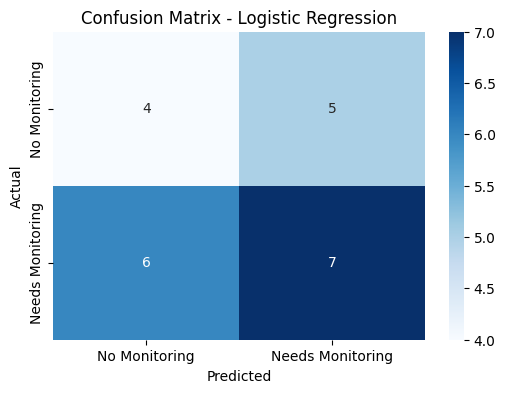


Training Random Forest...
Accuracy: 0.545
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.59      0.77      0.67        13

    accuracy                           0.55        22
   macro avg       0.49      0.50      0.48        22
weighted avg       0.51      0.55      0.51        22



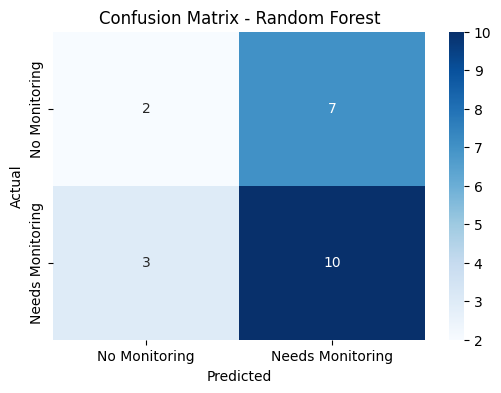


Training Gradient Boosting...
Accuracy: 0.591
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.64      0.69      0.67        13

    accuracy                           0.59        22
   macro avg       0.57      0.57      0.57        22
weighted avg       0.58      0.59      0.59        22



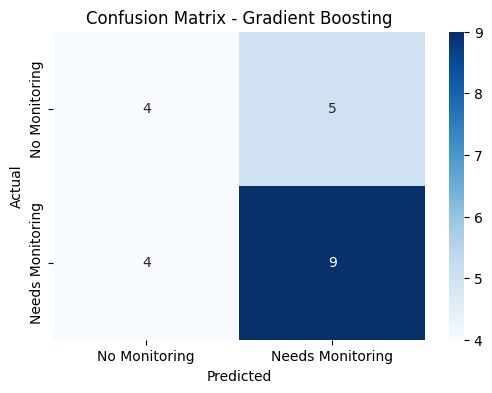


Training SVM...
Accuracy: 0.545
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.60      0.69      0.64        13

    accuracy                           0.55        22
   macro avg       0.51      0.51      0.51        22
weighted avg       0.53      0.55      0.53        22



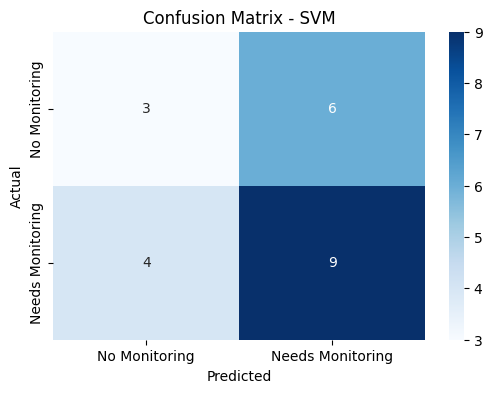


MODEL COMPARISON
Logistic Regression: Accuracy = 0.500
Random Forest: Accuracy = 0.545
Gradient Boosting: Accuracy = 0.591
SVM: Accuracy = 0.545

Best model: Gradient Boosting


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'feature_importance': getattr(model, 'feature_importances_', None) if hasattr(model, 'feature_importances_') else None
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Monitoring', 'Needs Monitoring'],
                yticklabels=['No Monitoring', 'Needs Monitoring'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Compare model performance
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

for name, result in results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.3f}")

# Select the best model based on accuracy
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")


Feature Importance (Random Forest):
                 feature  importance
3   surgery_duration_min    0.233731
4             pain_level    0.214865
10          surgery_type    0.114316
1           bmi_baseline    0.090378
0           age_baseline    0.065904
6   neuro_hba1c_baseline    0.061250
5   neuro_ienfd_baseline    0.046489
11       anesthesia_type    0.044735
7              neuro_nds    0.037161
9                 gender    0.035918
2           has_diabetes    0.029034
8              neuro_nss    0.026218


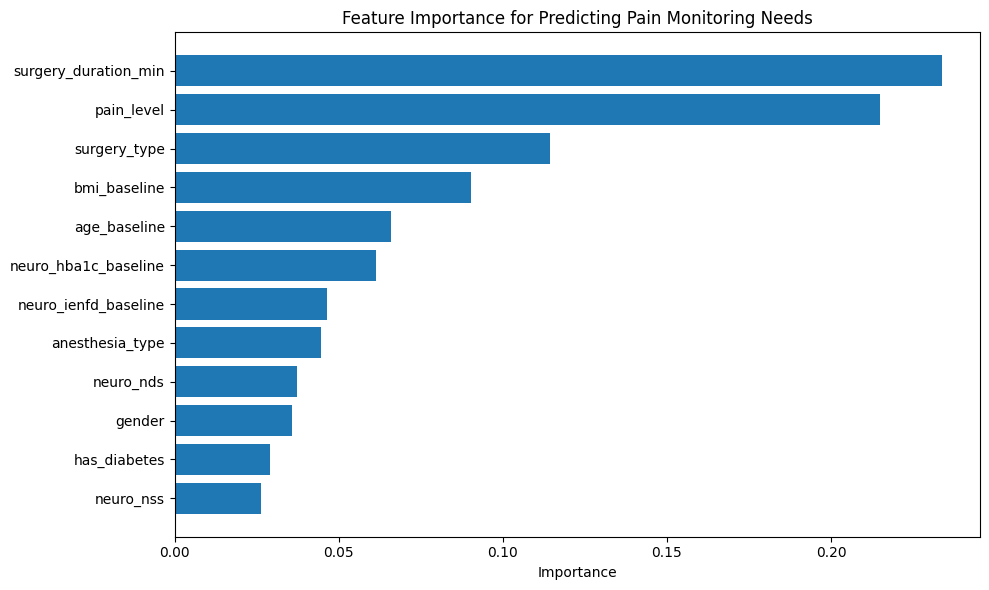

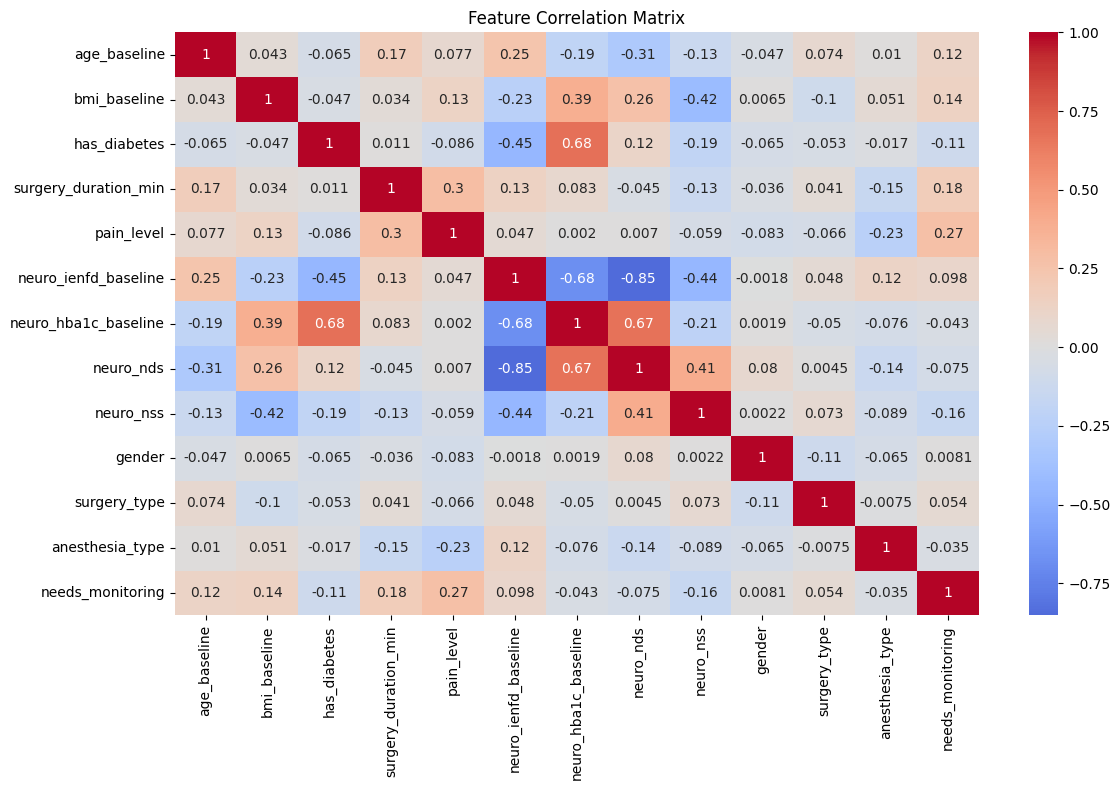

In [36]:
# Analyze feature importance for tree-based models
if results['Random Forest']['feature_importance'] is not None:
    # Get feature importance from Random Forest
    feature_importance = results['Random Forest']['feature_importance']
    feature_names = available_features
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance (Random Forest):")
    print(importance_df)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Predicting Pain Monitoring Needs')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Correlation analysis
correlation_df = pd.DataFrame(X_imputed, columns=available_features)
correlation_df['needs_monitoring'] = y.reset_index(drop=True)

plt.figure(figsize=(12, 8))
correlation_matrix = correlation_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [37]:
def predict_pain_monitoring_risk(new_patient_data, model, scaler, imputer, label_encoders, feature_names):
    """
    Predict if a new patient needs close pain medication monitoring
    """
    # Create a dataframe from the input
    patient_df = pd.DataFrame([new_patient_data])
    
    # Preprocess the data (same as training)
    for col in patient_df.select_dtypes(include=['object']).columns:
        if col in label_encoders:
            patient_df[col] = label_encoders[col].transform(patient_df[col].astype(str))
    
    # Ensure all features are present and in correct order
    for feature in feature_names:
        if feature not in patient_df.columns:
            patient_df[feature] = np.nan  # Add missing features
    
    patient_df = patient_df[feature_names]  # Reorder columns
    
    # Handle missing values and scale
    patient_processed = imputer.transform(patient_df)
    patient_scaled = scaler.transform(patient_processed)
    
    # Make prediction
    prediction = model.predict(patient_scaled)[0]
    probability = model.predict_proba(patient_scaled)[0][1]
    
    return prediction, probability

# Example usage:
example_patient = {
    'age_baseline': 65,
    'bmi_baseline': 28,
    'has_diabetes': 1,
    'surgery_duration_min': 120,
    'pain_level': 7,
    'neuro_ienfd_baseline': 1.5,  # Low nerve fiber density
    'neuro_hba1c_baseline': 52,    # High HbA1c (poor diabetes control)
    'gender': 'F',
    'surgery_type': 'Orthopedic',
    'anesthesia_type': 'General'
}

prediction, probability = predict_pain_monitoring_risk(
    example_patient, best_model, scaler, imputer, label_encoders, available_features
)

print(f"\nPrediction for example patient:")
print(f"Needs close monitoring: {'YES' if prediction == 1 else 'NO'}")
print(f"Probability: {probability:.3f}")
print(f"Risk level: {'HIGH' if probability > 0.7 else 'MODERATE' if probability > 0.3 else 'LOW'}")


Prediction for example patient:
Needs close monitoring: YES
Probability: 0.962
Risk level: HIGH


In [38]:
import joblib

# Save the entire pipeline
pipeline = {
    'model': best_model,
    'scaler': scaler,
    'imputer': imputer,
    'label_encoders': label_encoders,
    'feature_names': available_features,
    'model_name': best_model_name
}

joblib.dump(pipeline, 'pain_monitoring_predictor.pkl')
print("Model pipeline saved as 'pain_monitoring_predictor.pkl'")

# Save the feature importance
importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance saved as 'feature_importance.csv'")

Model pipeline saved as 'pain_monitoring_predictor.pkl'
Feature importance saved as 'feature_importance.csv'


In [51]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

def get_float_input(prompt, default_value=None):
    """Safe function to get numeric input with error handling"""
    while True:
        try:
            value = input(prompt)
            if value == '' and default_value is not None:
                return default_value
            return float(value)
        except ValueError:
            print("Please enter a valid number!")

def get_patient_input():
    """Get comprehensive patient input for accurate prediction"""
    print("=== PAIN MONITORING RISK ASSESSMENT ===")
    print("Press Enter to use default values if information is not available\n")
    
    patient_data = {}
    
    # Basic information with error handling
    patient_data['Age'] = get_float_input("Age: ", 45.0)  # Default: 45
    patient_data['BMI'] = get_float_input("BMI: ", 25.0)   # Default: 25
    
    # Gender input with validation
    while True:
        gender = input("Gender (M/F): ").upper()
        if gender in ['M', 'F', '']:
            patient_data['Gender'] = gender if gender != '' else 'M'  # Default: Male
            break
        else:
            print("Please enter M or F!")
    
    # Diabetes status
    diabetes_input = input("Diabetes? (yes/no) [default: no]: ").lower()
    patient_data['HasDiabetes'] = 1 if diabetes_input in ['yes', 'y', '1'] else 0
    
    # Pain level and surgery duration
    patient_data['PainLevel'] = get_float_input("Expected pain level (1-10) [default: 5]: ", 5.0)
    patient_data['SurgeryDuration'] = get_float_input("Surgery duration (minutes) [default: 120]: ", 120.0)
    
    # Surgery type with validation
    print("\nSurgery Type Options:")
    print("1. Neurological, 2. Cardiovascular, 3. Orthopedic, 4. Cosmetic")
    while True:
        surgery_choice = input("Enter choice (1-4) [default: 3]: ") or "3"
        if surgery_choice in ['1', '2', '3', '4']:
            surgery_types = ['Neurological', 'Cardiovascular', 'Orthopedic', 'Cosmetic']
            patient_data['SurgeryType'] = surgery_types[int(surgery_choice)-1]
            break
        else:
            print("Please enter 1, 2, 3, or 4!")
    
    # Anesthesia type with validation
    print("\nAnesthesia Type Options:")
    print("1. General, 2. Local")
    while True:
        anesthesia_choice = input("Enter choice (1-2) [default: 1]: ") or "1"
        if anesthesia_choice in ['1', '2']:
            anesthesia_types = ['General', 'Local']
            patient_data['AnesthesiaType'] = anesthesia_types[int(anesthesia_choice)-1]
            break
        else:
            print("Please enter 1 or 2!")
    
    # Neuropathy data (optional)
    print("\n--- Optional Neuropathy Data (press Enter to skip) ---")
    patient_data['IENFD_baseline'] = get_float_input("IENFD score [default: 2.0]: ", 2.0)
    patient_data['HbA1c_baseline'] = get_float_input("HbA1c level [default: 40.0]: ", 40.0)
    
    return patient_data

def load_trained_model():
    """Load your actual trained model and preprocessing objects"""
    try:
        # For now, let's create a simple model for demonstration
        # In real use, you'd load your actual trained model
        print("⚠️  Using demonstration mode (simple model)")
        print("   Train and save your model first for real predictions")
        return None
    except FileNotFoundError:
        print("❌ Model file not found. Please train the model first.")
        return None

def predict_with_real_model(patient_data, pipeline):
    """Use your ACTUAL trained model for prediction"""
    # For demonstration purposes - replace with your actual model
    print("\n📊 Using patient data for prediction:")
    for key, value in patient_data.items():
        print(f"   {key}: {value}")
    
    # Simple demonstration logic (REPLACE WITH YOUR ACTUAL MODEL)
    risk_factors = 0
    if patient_data['Age'] > 60: risk_factors += 1
    if patient_data['BMI'] > 30: risk_factors += 1
    if patient_data['HasDiabetes'] == 1: risk_factors += 1
    if patient_data['PainLevel'] > 7: risk_factors += 1
    if patient_data['IENFD_baseline'] < 2.0: risk_factors += 1
    
    # Simulate prediction
    probability = min(0.2 + (risk_factors * 0.15), 0.95)
    prediction = 1 if probability > 0.5 else 0
    
    return prediction, probability, risk_factors  # Return risk_factors

def main():
    """Main function using your REAL trained model"""
    print("Medical Pain Monitoring Risk Assessment")
    print("=======================================")
    
    # Load your actual trained model
    pipeline = load_trained_model()
    
    # Get patient input
    patient_data = get_patient_input()
    
    # Get prediction
    prediction, probability, risk_factors = predict_with_real_model(patient_data, pipeline)
    
    # Display results - USE THE RETURNED risk_factors, NOT patient_data.values()
    print("\n" + "="*50)
    print("🤖 AI PREDICTION RESULTS")
    print("="*50)
    print(f"Prediction: {'NEEDS CLOSE MONITORING' if prediction == 1 else 'ROUTINE MONITORING'}")
    print(f"Confidence Level: {probability:.1%}")
    print(f"Risk Factors Identified: {risk_factors}")  # FIXED: Use risk_factors instead
    
    if probability > 0.7:
        print("\n🟥 HIGH RISK - Intensive monitoring required")
        print("• Frequent pain assessments (every 1-2 hours)")
        print("• Multi-modal pain management strategy")
        print("• Consider pre-emptive medication")
    elif probability > 0.4:
        print("\n🟨 MODERATE RISK - Enhanced monitoring recommended")
        print("• Regular pain checks (every 3-4 hours)")
        print("• Proactive pain management")
    else:
        print("\n🟩 LOW RISK - Standard monitoring sufficient")
        print("• Routine pain assessment protocol")
    
    print("\n" + "="*50)

# Run the application
if __name__ == "__main__":
    main()

Medical Pain Monitoring Risk Assessment
⚠️  Using demonstration mode (simple model)
   Train and save your model first for real predictions
=== PAIN MONITORING RISK ASSESSMENT ===
Press Enter to use default values if information is not available


Surgery Type Options:
1. Neurological, 2. Cardiovascular, 3. Orthopedic, 4. Cosmetic

Anesthesia Type Options:
1. General, 2. Local

--- Optional Neuropathy Data (press Enter to skip) ---

📊 Using patient data for prediction:
   Age: 27.0
   BMI: 25.0
   Gender: F
   HasDiabetes: 0
   PainLevel: 7.0
   SurgeryDuration: 150.0
   SurgeryType: Orthopedic
   AnesthesiaType: Local
   IENFD_baseline: 2.0
   HbA1c_baseline: 50.0

🤖 AI PREDICTION RESULTS
Prediction: ROUTINE MONITORING
Confidence Level: 20.0%
Risk Factors Identified: 0

🟩 LOW RISK - Standard monitoring sufficient
• Routine pain assessment protocol

